<a href="https://colab.research.google.com/github/LuFernandez/imagaynes/blob/master/Restauracion_imgs/restore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP - Restauración de Imágenes
###Ezequiel Vijande
###Lucero Guadalupe Fernandez

###Imports a utilizar

In [8]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
from numpy.fft import fft2,fftshift,ifft2,ifftshift

####Cargamos imágenes

In [9]:
!wget https://raw.githubusercontent.com/lufernandez/imagaynes/master/Restauracion_imgs/pic/lenna.png
clear_output()

####mostramos imagen original y definimos funciones a utilizar

In [10]:
#definimos la funcion del filtro: recibe el tamaño del kernel,
#y la imagen sobre la que se aplica el filtro, se usa filtro promediador
def ApplyBlur(img, kernel): #lowpass
  kernel = ExpandKernel(kernel, (img).shape)
  blur = fft2(img[:,:,0])*fft2(kernel)
  return np.real(fftshift(ifft2(blur)))

def ApplyNoise(img, std=1):
  row,col = img.shape
  mean = 0
  gauss = np.random.normal(mean,std,(row,col))
  gauss = gauss.reshape(row,col)
  noisy = img.astype(float) + gauss.astype(float)
  return noisy.astype(np.float)


def ExpandKernel(kernel, size):
  delta = np.zeros((size[0], size[1]), dtype=float)
  delta[size[0]//2,size[1]//2] = 1
  return cv2.filter2D(delta, -1, kernel)

#https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
def gkern(kernlen=21, std=3):
  """Returns a 2D Gaussian kernel array."""
  gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
  gkern2d = np.outer(gkern1d, gkern1d)
  gkern2d /= np.sum(gkern2d)
  return gkern2d


def ApplyInverseFilter(degraded_og, kernel):
  degraded = degraded_og.copy()
  kernel = ExpandKernel(kernel, (degraded).shape)
  #Kernel Spectrum
  H = fft2(kernel) 
  #Degraded image spectrum
  G = fft2(degraded)
  # Inverse Filter 
  F_hat = fftshift(G/(H))
  restored = np.real(fftshift(ifft2(ifftshift(F_hat))))
  return restored


In [13]:
def mse(img1, original):
  return np.mean((img1-original[:,:,0])**2)
  
#ploteamos secuencia
def MakeSubplot(img,fig,row,column,index,title):
  fig.add_subplot(row,column,index)
  plt.title(title)
  plt.axis('off')
  plt.imshow(img,cmap='gray', vmin=0, vmax=255)

##1. Inverse Filter

###a. Blur

MSE entre imagen original y la imagen con blur es: 85.66060325249862
MSE entre imagen original y la restaurada es: 3.007231768621587e-23


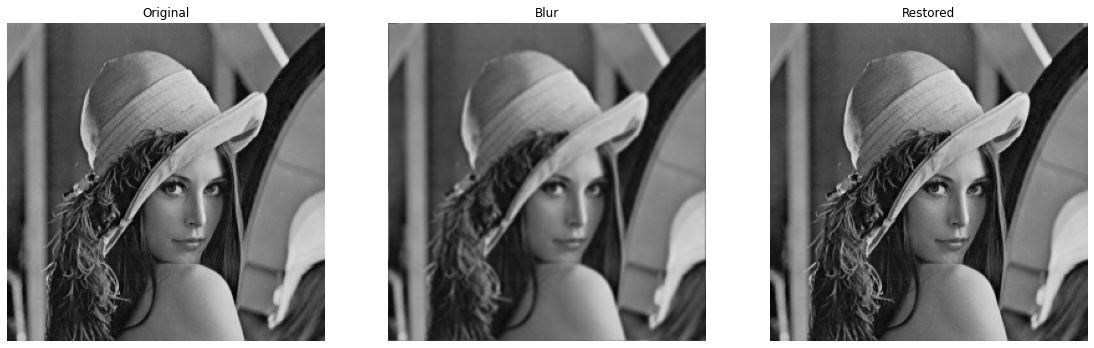

In [15]:
#imagen original
lenna = cv2.imread('lenna.png')

#kernel = np.full((3, 3), 1)/(3**2)
kernel = gkern(kernlen=3, std=20)

degraded = ApplyBlur(lenna, kernel)
blurred = degraded.copy()
restored = ApplyInverseFilter(degraded, kernel)

fig_a = plt.figure(figsize=(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)
MakeSubplot(lenna,fig_a,1,3,1,title="Original")
MakeSubplot(degraded.astype(int),fig_a,1,3,2,title="Blur")
MakeSubplot(restored,fig_a,1,3,3,title="Restored")

print('MSE entre imagen original y la imagen con blur es:', mse(blurred, lenna))
print('MSE entre imagen original y la restaurada es:', mse(restored, lenna))

Se obtiene un muy bajo error usando Inverse filter en el caso de blur.

###b. Blur + Noise

MSE entre imagen original y la imagen con blur+noise es: 186.31291608620518
MSE entre imagen original y la restaurada es: 406.8103878042581


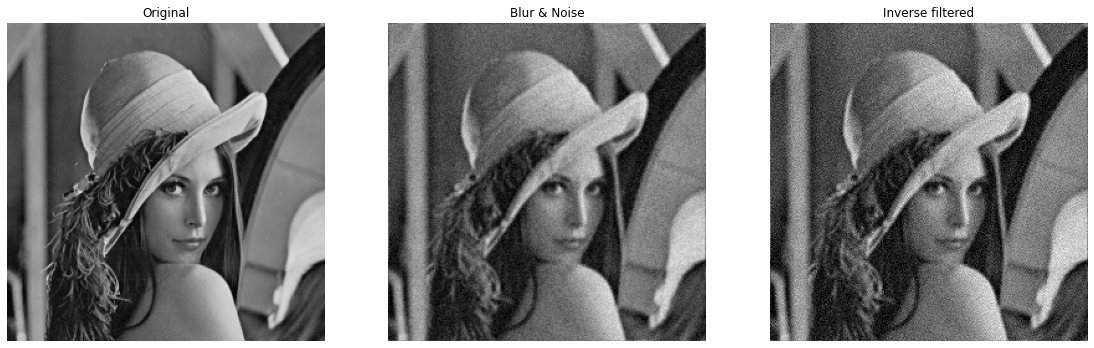

In [19]:
#Original
blur_noisy = ApplyNoise(blurred,std=10)
kernel = gkern(kernlen=3, std=.5)
restored_noisy = ApplyInverseFilter(blur_noisy, kernel)

fig_a = plt.figure(figsize=(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)

MakeSubplot(lenna,fig_a,1,3,1,title="Original")
MakeSubplot(blur_noisy.astype(int),fig_a,1,3,2,title="Blur & Noise")
MakeSubplot(restored_noisy.astype(int),fig_a,1,3,3,title="Inverse filtered")

print('MSE entre imagen original y la imagen con blur+noise es:', mse(blur_noisy, lenna))
print('MSE entre imagen original y la restaurada es:', mse(restored_noisy, lenna))

En este caso (blur+noise) no es de utilidad usar Inverse filter.

## 2- Wiener filter (Blur + Noise)

In [20]:
def WienerRestore(kernel,degraded_img,noise_std=None,original_img=None):
  expanded_kernel = ExpandKernel(kernel, degraded_img.shape)
  H = np.fft.fft2( np.fft.ifftshift(expanded_kernel) )
  H_power = np.power(abs(H), 2* np.ones(H.shape))
  L= 1e-1
  if (noise_std == None):
    W = np.conjugate(H) / (H_power + L)
  else:
    img_mod = abs( np.fft.fft2( original_img[:,:,0] ) )
    Sxx = np.power( img_mod, 2* np.ones(img_mod.shape)) / (img_mod.shape[0] * img_mod.shape[1])
    Snn = (noise_std*noise_std) * np.ones( Sxx.shape ) 
    W = np.conjugate(H) / (H_power + (Snn/Sxx) ) 
  F_hat = np.fft.fft2( degraded_img ) * W
  aux = np.nan_to_num(F_hat)
  restored = abs( np.fft.ifft2( aux )  ) 
  restored[restored < 0] = 0
  restored[restored > 255] = 255
  return restored.astype(int)

MSE entre imagen original y la imagen con blur+noise es: 485.7812989439067
MSE entre imagen original y la restaurada es: 147.96826171875


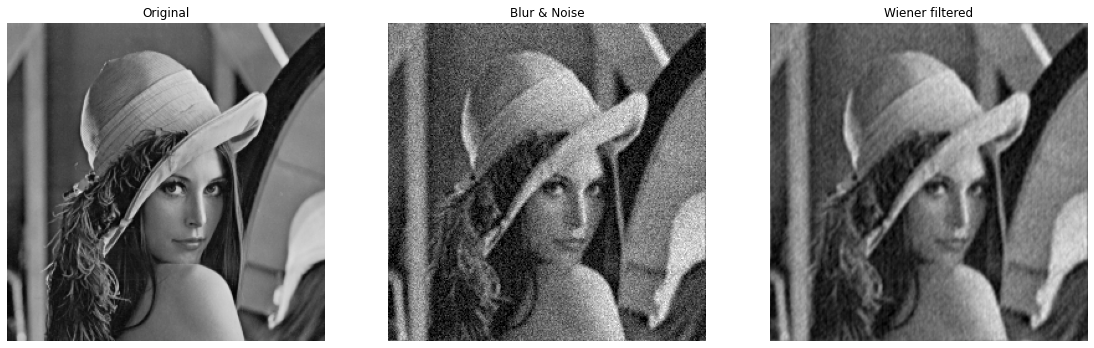

In [22]:
#Original
std_ = 20
blur_noisy = ApplyNoise(degraded,std=std_)
restored_noisy = WienerRestore(kernel.astype(float),blur_noisy.astype(float),noise_std=std_,original_img=lenna.astype(float))

fig_a = plt.figure(figsize=(15,15))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)

MakeSubplot(lenna,fig_a,1,3,1,title="Original")
MakeSubplot(blur_noisy.astype(int),fig_a,1,3,2,title="Blur & Noise")
MakeSubplot(restored_noisy.astype(int),fig_a,1,3,3,title="Wiener filtered")

print('MSE entre imagen original y la imagen con blur+noise es:', mse(blur_noisy, lenna))
print('MSE entre imagen original y la restaurada es:', mse(restored_noisy, lenna))

## 3- Blind deconvolution